# Group information

In [1]:
import pandas as pd
import time
import os
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

print("pandas",pd.__version__)
print("numpy",np.__version__)
print("matplotlib",mpl.__version__)
print("seaborn",sns.__version__)

### setup ###
# Data Directory
data_dir = '/Users/chidakatsuyuki/Desktop/Project/raw_JMDC/'
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
output_csv_dir = current_path + 'NephroticSyndrome_csv/'
if not os.path.exists(output_csv_dir):
    os.mkdir(output_csv_dir)

output_image_dir = current_path +"NephroticSyndrome_image/"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)

mpl.style.use("default")
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42 
mpl.rcParams['ps.fonttype'] = 42

pandas 1.3.4
numpy 1.22.4
matplotlib 3.6.3
seaborn 0.11.2


In [2]:
# Read processed data
use_cols= ['Enrollee ID', 'Sex', 'Observation_start_yyyymm', 'Observation_end_yyyymm', "Target_diag_yyyymm",'Age_at_start','Target']
df_p = pd.read_csv (output_csv_dir+'patient/Group_diseases.csv',
                   )#usecols=use_cols).drop_duplicates()
df_c = pd.read_csv (output_csv_dir+'control/Group_diseases.csv',
                   )#usecols=use_cols).drop_duplicates()

In [3]:
df = pd.concat([df_p,df_c]).drop_duplicates("Enrollee ID").reset_index(drop=True)
df.head()

,Enrollee ID,Record_yyyymm,ICD10_3_Code,Suspicious_flag,First_diagnosis_yyyymmdd,Death_flag,Birth_date,Sex,Inssured_or_Family,Observation_start_yyyymm,Observation_end_yyyymm,Death_censor,Target_diag_yyyymm,Taget_diag_from_start,Age_at_start,Obsevation_length,matched_ID,Months_from_target_diag,Target,matched_flg
0,M000051963,201701,E78,NaN,20141118.0,NaN,197411,Female,Family,201101,201903,NaN,201411,46.0,36,98,M000167622,26,1,NaN
1,M000055609,201208,J30,NaN,20111107.0,NaN,195203,Male,Inssured_person,201203,201903,NaN,201504,37.0,60,84,M000846832,-32,1,NaN
2,M000084358,201505,H04,NaN,20150430.0,NaN,196507,Female,Family,200501,201903,NaN,201502,121.0,39,170,M000006928,3,1,NaN
3,M000355777,201411,L85,NaN,20140128.0,NaN,198712,Male,Inssured_person,201204,201803,NaN,201803,71.0,24,71,M000261499,-40,1,NaN
4,M000369339,201109,J45,NaN,20110928.0,NaN,197411,Male,Inssured_person,200501,201903,NaN,201505,124.0,30,170,M000024556,-44,1,NaN


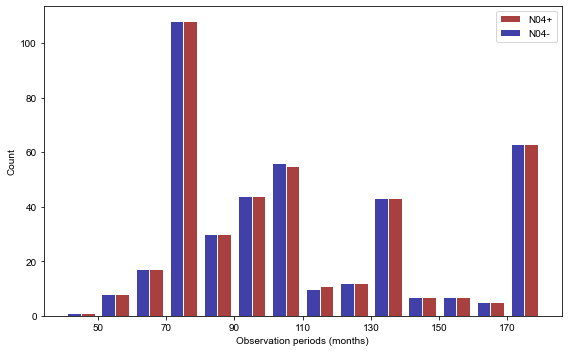

In [4]:
# The observation periods (Figure1b)
df["Obsevation_length"]= pd.to_datetime(df["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')

color_dict ={0:"darkblue", 1: "darkred"}
plt.figure(figsize = (8,5))
sns.histplot(data = df, 
             bins = range(40, 190, 10),
             x = "Obsevation_length", 
             hue = "Target", 
             multiple="dodge", shrink=.8,
             element = "bars", edgecolor = "w",
             palette = color_dict,
            )
plt.xlabel("Observation periods (months)")
plt.legend(["N04+","N04-"])
plt.xticks([50,70,90,110,130,150,170])
plt.tight_layout()

plt.savefig(output_image_dir + "Observation_periods.pdf")

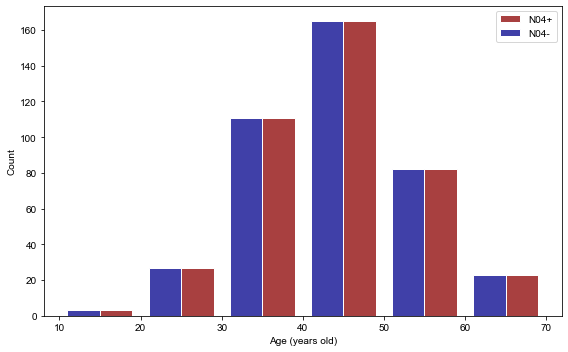

In [5]:
# Age at the observation start (Figure1c)
plt.figure(figsize = (8,5))
sns.histplot(data = df, 
             bins = range(10, 80, 10),
             x = 'Age_at_start', hue = "Target", 
             multiple="dodge", shrink=.8,
             element = "bars", edgecolor = "w",
             palette = color_dict
            )
plt.xlabel("Age (years old)")
plt.legend(["N04+","N04-"])


plt.tight_layout()
plt.savefig(output_image_dir + "Age_at_observation_start.pdf")

Stop: Fri May 17 13:40:55 2024


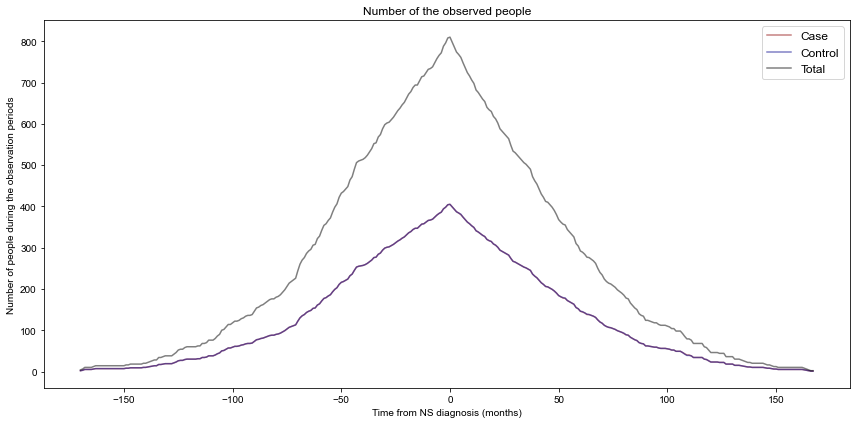

In [6]:
# Number of subjects being observed (Figure2a)

# To the observation start
df["To_observation_start"]= pd.to_datetime(df["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
# To the observation end
df["To_observation_end"] = pd.to_datetime(df["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
# X-axis (timepoints)
time_points = np.arange(start =df["To_observation_start"].min(),stop=df["To_observation_end"].max()+1)



output_total = True
# Figure and group setting
fig, ax = plt.subplots(figsize=[12,6])
case_con ={"Case": 1, "Control":0}
color_dict={"Case": "darkred", "Control":"darkblue"}

df_ovsnum = pd.DataFrame(data = {"Time_point":time_points})
for key in case_con.keys():
    # Counts individuals
    for i in range(len(df_ovsnum)-1):
        df_ovsnum.loc[i, f"{key}_Counts"] = df[df["Target"]==case_con[key]].apply(lambda x: (
            (x["To_observation_start"] <= df_ovsnum.loc[i, "Time_point"])&(df_ovsnum.loc[i+1, "Time_point"] <= x["To_observation_end"]
                                                                              )), axis = 1).sum()
    df_ovsnum.loc[len(df_ovsnum)-1, f"{key}_Counts"] = df[df["Target"]==case_con[key]].apply(lambda x: df_ovsnum.loc[i+1, "Time_point"] <= x["To_observation_end"], axis = 1).sum()
    
    # Graph 
    ax.plot("Time_point",f"{key}_Counts", data = df_ovsnum, alpha =0.5, c=color_dict[key])

# Total
if output_total == True:
    df_ovsnum["Total"] = df_ovsnum["Case_Counts"]+df_ovsnum["Control_Counts"]
    ax.plot("Time_point","Total", data = df_ovsnum, alpha =0.5, c="k")
plt.title("People under the observation")
plt.legend(labels = ["Case","Control","Total"], fontsize = 12)
ax.set_ylabel("Number of people during the observation periods")
ax.set_xlabel("Time from NS diagnosis (months)")
ax.set_title("Number of the observed people")
plt.tight_layout()

fig.savefig(output_image_dir + f"Observed people_total_{output_total}.pdf")
print("Stop:",time.asctime(time.gmtime(time.time())))

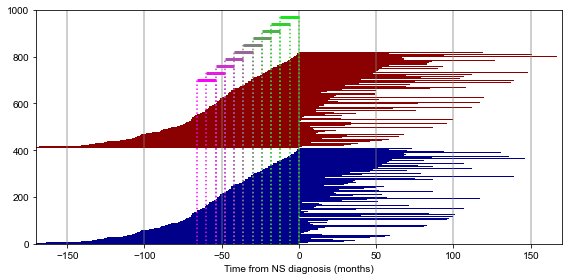

In [7]:
# Visualize each observation period (Figure 2b)
# Used data 

df_life = df[["Enrollee ID", "To_observation_start", "To_observation_end", "Target"]]
df_life = df_life.sort_values(by = ["Target", "To_observation_start"],kind="mergesort")

# Set analysis periods
dict_periods = {
    '-60m':[-66,-54],
    '-54m':[-60,-48],
    '-48m':[-54,-42],
    '-42m':[-48,-36],
    '-36m':[-42,-30],
    '-30m':[-36,-24],
    '-24m':[-30,-18],
    '-18m':[-24,-12],
    '-12m':[-18,-6],
    '-06m':[-12,0],
    }


# Figure setting
fig, ax = plt.subplots(figsize=[8,4])
color_dict ={0:"darkblue", 1: "darkred"}
ax.set_ylim(0, 1000)
ax.set_xlim(-170,170)

# Draw vertical lines
ax.vlines(x = [-150,-100,-50,0,50,100,150],
              ymin =0, 
              ymax = 1000, 
              colors =   "gray",
              linestyles = "solid",
              facecolor = "gray",
              alpha=0.5)

# Draw observation periods of each patient
ax.barh(range(len(df_life)), 
        width = df_life["To_observation_end"]-df_life["To_observation_start"],
        height = 1, 
        left = df_life["To_observation_start"],
        align = "edge",
        color = [color_dict[x] for x in df_life["Target"]])

# Add analysis window
for i, period in enumerate(dict_periods):
    ax.hlines(y =[700+(i*30), -3], 
              xmin =dict_periods[period][0] , 
              xmax = dict_periods[period][1],
              colors = (1-0.1*i,0.1*i,1-0.1*i),
              linewidths = 3,
              facecolor = "w"
              )
    ax.vlines(x = [dict_periods[period][0],dict_periods[period][1]],
              ymin = -3, 
              ymax = 700+(i*30), 
              colors =   (1-0.1*i,0.1*i,1-0.1*i),
              linestyles = "dotted",
              facecolor = "w"
              )

ax.set_xlabel("Time from NS diagnosis (months)")
plt.tight_layout()
mpl.rcParams['savefig.edgecolor']= '#ffffff'
mpl.rcParams['savefig.facecolor']= '#ffffff'
mpl.rcParams['axes.facecolor'] =  '#ffffff'
mpl.rcParams['grid.color'] =  (0,0,0)
plt.savefig(output_image_dir+"analysis_windows.pdf")